In [1]:
!pip install xgboost lightgbm catboost -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import sklearn modules
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import advanced models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


✓ All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


In [4]:
"""
Load train.csv, test.csv, and examine data_description.txt
IMPORTANT: Upload your files to Colab first!
"""

# Load the datasets
# Note: Make sure train.csv and test.csv are uploaded to your Colab environment
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\n📊 Training set shape: {train_df.shape}")
print(f"📊 Test set shape: {test_df.shape}")
print(f"📊 Sample submission shape: {sample_submission.shape}")

print("\n" + "=" * 80)
print("FIRST 5 ROWS OF TRAINING DATA")
print("=" * 80)
print(train_df.head())

print("\n" + "=" * 80)
print("DATA TYPES AND MISSING VALUES")
print("=" * 80)
print(train_df.info())


DATASET OVERVIEW

📊 Training set shape: (1460, 81)
📊 Test set shape: (1459, 80)
📊 Sample submission shape: (1459, 2)

FIRST 5 ROWS OF TRAINING DATA
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoR

TARGET VARIABLE ANALYSIS: SalePrice

📈 Descriptive Statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

📊 Skewness: 1.8829
📊 Kurtosis: 6.5363


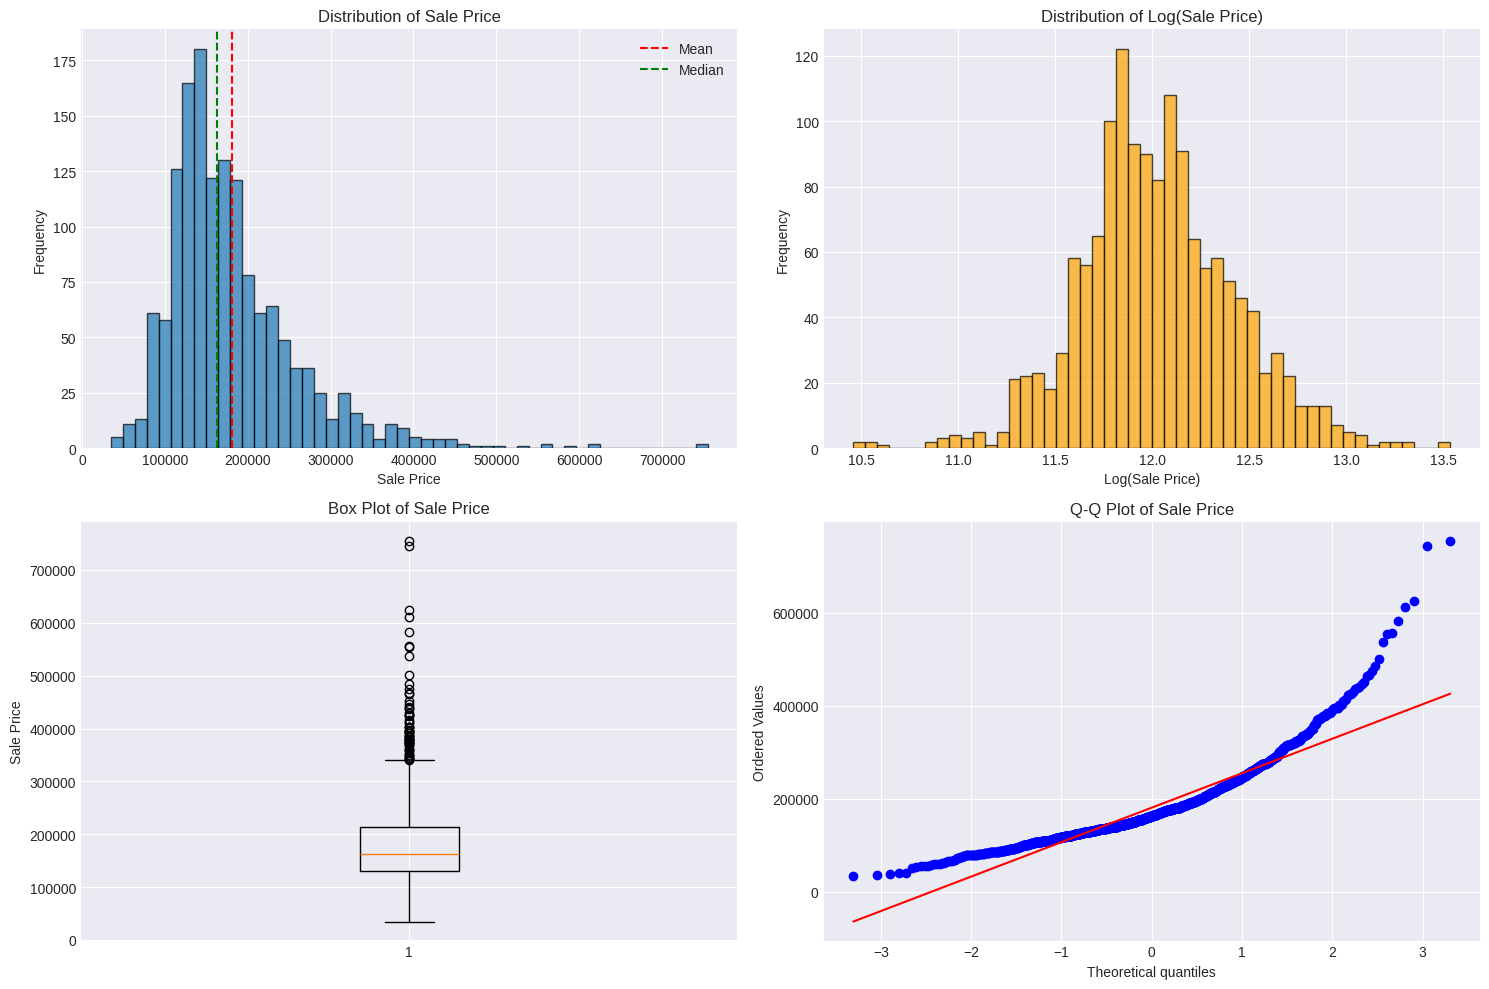


✓ Target variable analysis complete!


In [5]:
"""
Analyze the target variable (SalePrice) distribution and statistics
"""

print("=" * 80)
print("TARGET VARIABLE ANALYSIS: SalePrice")
print("=" * 80)

# Statistical summary
print("\n📈 Descriptive Statistics:")
print(train_df['SalePrice'].describe())

# Check for skewness and kurtosis
skewness = train_df['SalePrice'].skew()
kurtosis = train_df['SalePrice'].kurtosis()
print(f"\n📊 Skewness: {skewness:.4f}")
print(f"📊 Kurtosis: {kurtosis:.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution plot
axes[0, 0].hist(train_df['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Sale Price')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Sale Price')
axes[0, 0].axvline(train_df['SalePrice'].mean(), color='red',
                    linestyle='--', label='Mean')
axes[0, 0].axvline(train_df['SalePrice'].median(), color='green',
                    linestyle='--', label='Median')
axes[0, 0].legend()

# Log-transformed distribution
axes[0, 1].hist(np.log1p(train_df['SalePrice']), bins=50,
                edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Log(Sale Price)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Log(Sale Price)')

# Box plot
axes[1, 0].boxplot(train_df['SalePrice'], vert=True)
axes[1, 0].set_ylabel('Sale Price')
axes[1, 0].set_title('Box Plot of Sale Price')

# Q-Q plot
from scipy import stats
stats.probplot(train_df['SalePrice'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Sale Price')

plt.tight_layout()
plt.show()

print("\n✓ Target variable analysis complete!")


MISSING VALUE ANALYSIS

📊 TRAINING SET - Missing Values:
Dataset has 81 columns.
There are 19 columns with missing values.
              Missing Values  % of Total Values
PoolQC                  1453              99.52
MiscFeature             1406              96.30
Alley                   1369              93.77
Fence                   1179              80.75
MasVnrType               872              59.73
FireplaceQu              690              47.26
LotFrontage              259              17.74
GarageType                81               5.55
GarageYrBlt               81               5.55
GarageFinish              81               5.55
GarageQual                81               5.55
GarageCond                81               5.55
BsmtExposure              38               2.60
BsmtFinType2              38               2.60
BsmtQual                  37               2.53
BsmtCond                  37               2.53
BsmtFinType1              37               2.53
MasVnrArea   

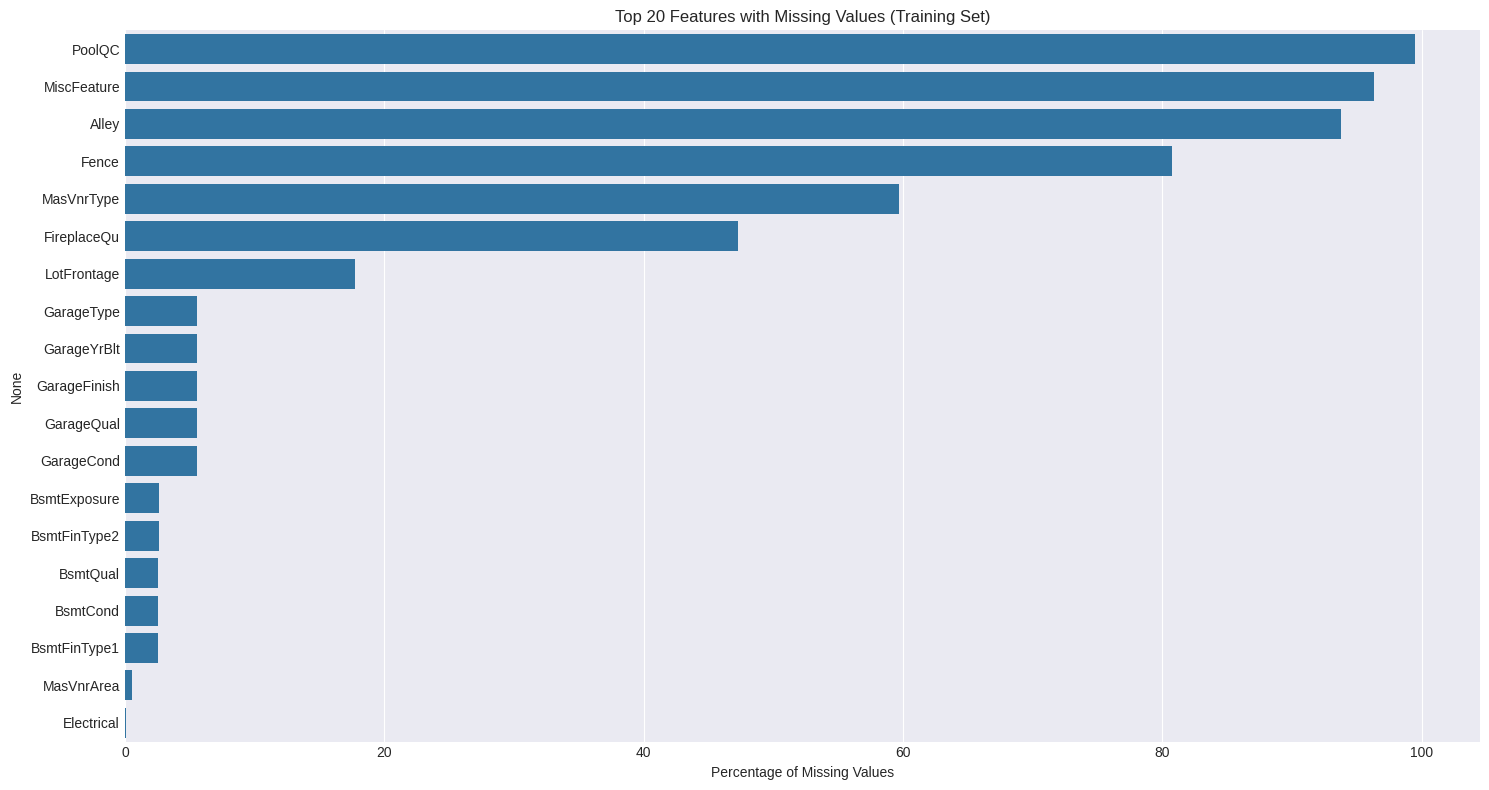


✓ Missing value analysis complete!


In [6]:
"""
Identify and visualize missing values in the dataset
"""

print("=" * 80)
print("MISSING VALUE ANALYSIS")
print("=" * 80)

# Calculate missing values
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table = mis_val_table[mis_val_table.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(2)
    print(f"Dataset has {df.shape[1]} columns.")
    print(f"There are {mis_val_table.shape[0]} columns with missing values.")
    return mis_val_table

print("\n📊 TRAINING SET - Missing Values:")
train_missing = missing_values_table(train_df)
print(train_missing)

print("\n📊 TEST SET - Missing Values:")
test_missing = missing_values_table(test_df)
print(test_missing)

# Visualize missing values
if len(train_missing) > 0:
    plt.figure(figsize=(15, 8))
    train_missing_top20 = train_missing.head(20)
    sns.barplot(x=train_missing_top20['% of Total Values'],
                y=train_missing_top20.index)
    plt.xlabel('Percentage of Missing Values')
    plt.title('Top 20 Features with Missing Values (Training Set)')
    plt.tight_layout()
    plt.show()

print("\n✓ Missing value analysis complete!")

CORRELATION ANALYSIS

📊 Top 15 Positive Correlations with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

📊 Top 10 Negative Correlations with SalePrice:
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


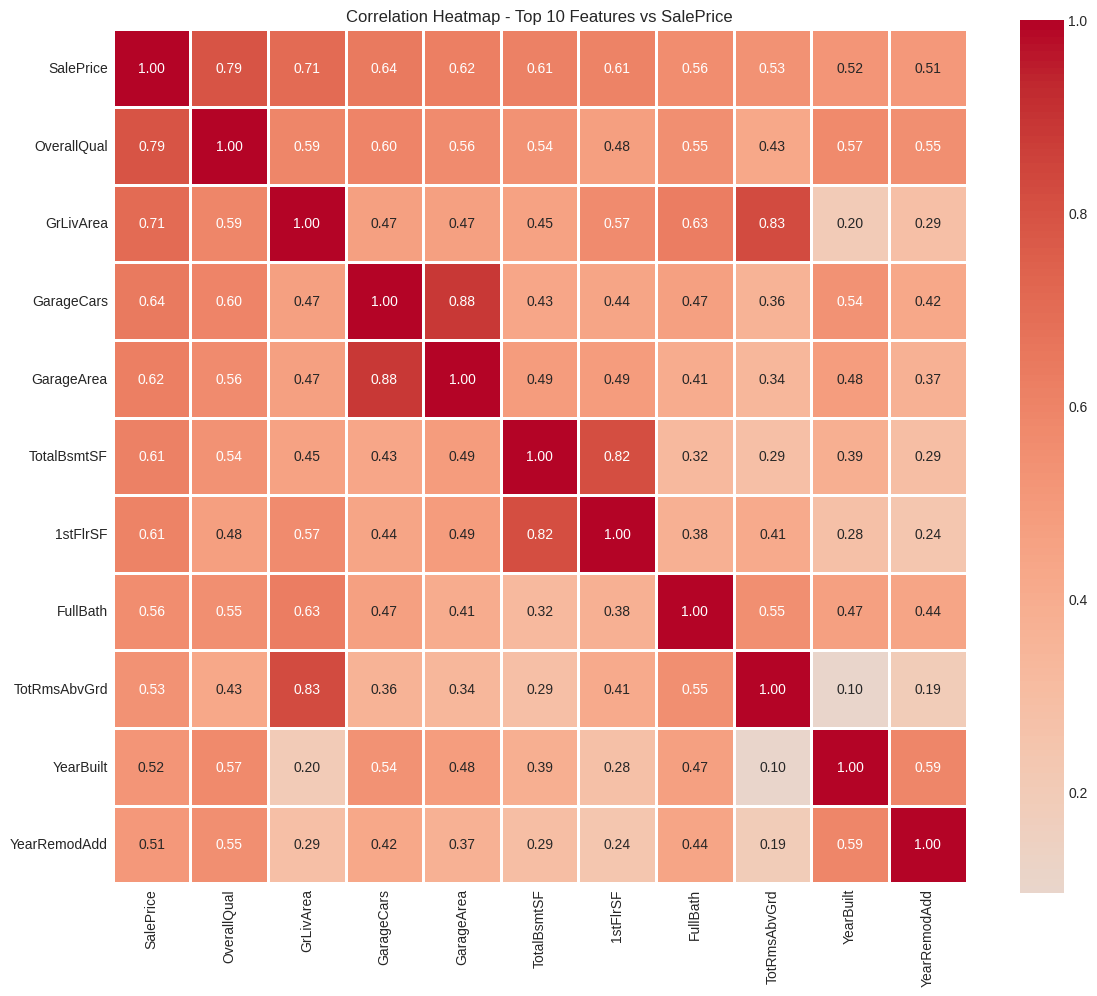


✓ Correlation analysis complete!


In [7]:
"""
Analyze correlations between features and target variable
"""

print("=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Select only numeric columns
numeric_features = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation with SalePrice
correlations = train_df[numeric_features].corr()['SalePrice'].sort_values(ascending=False)

print("\n📊 Top 15 Positive Correlations with SalePrice:")
print(correlations.head(15))

print("\n📊 Top 10 Negative Correlations with SalePrice:")
print(correlations.tail(10))

# Correlation heatmap for top features
top_features = correlations.head(11).index  # Top 10 + SalePrice
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[top_features].corr(), annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap - Top 10 Features vs SalePrice')
plt.tight_layout()
plt.show()

print("\n✓ Correlation analysis complete!")

KEY FEATURES VISUALIZATION


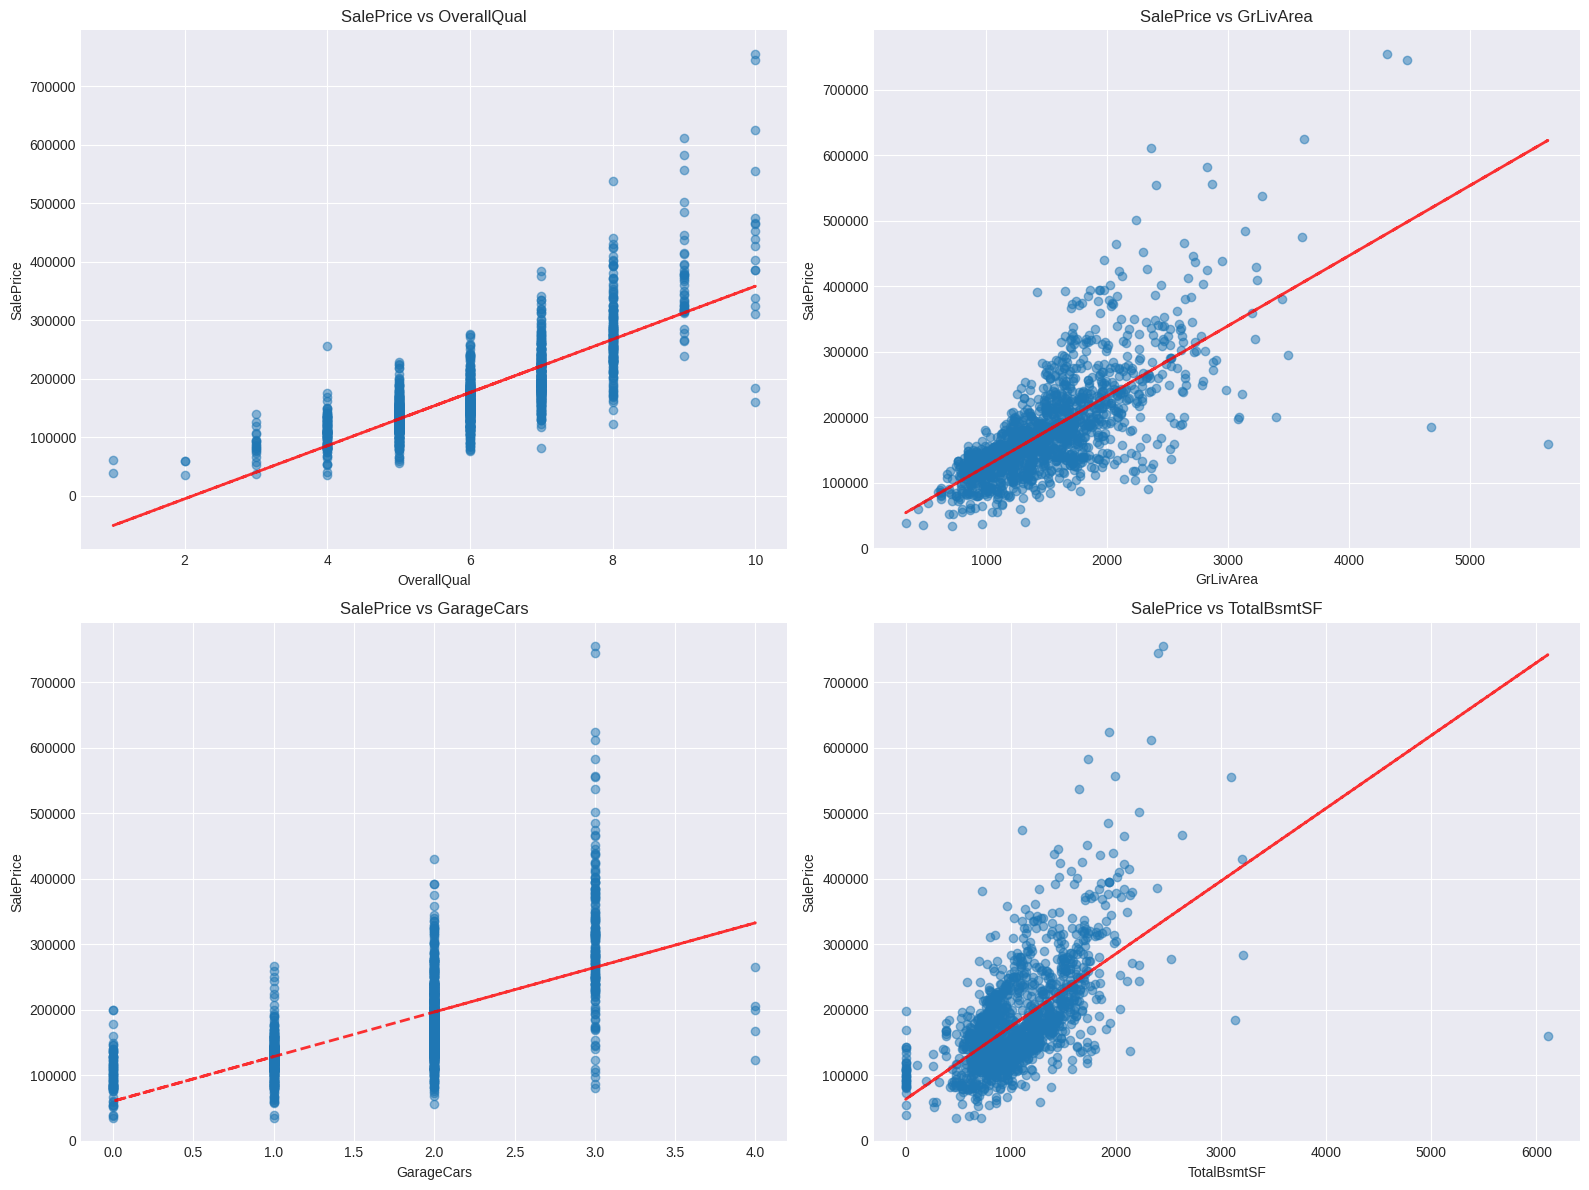

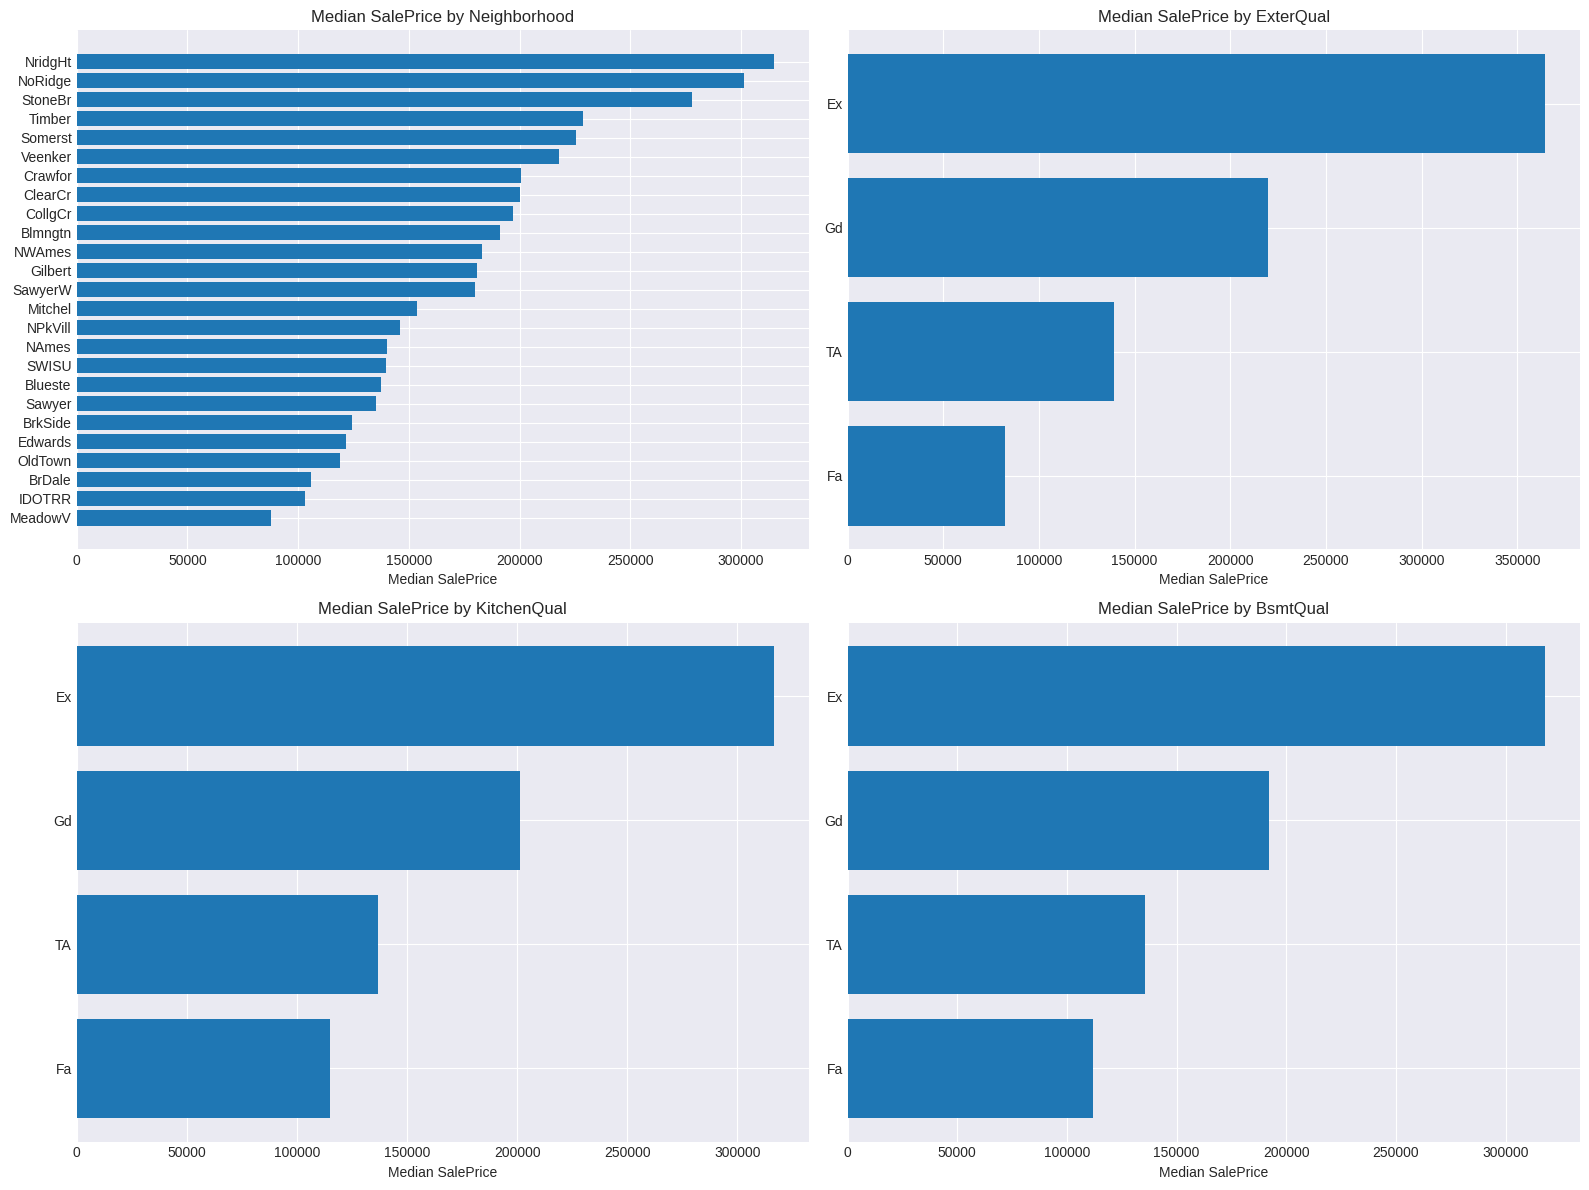


✓ Key features visualization complete!


In [8]:
"""
Visualize relationships between key features and SalePrice
"""

print("=" * 80)
print("KEY FEATURES VISUALIZATION")
print("=" * 80)

# Key numeric features to analyze
key_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    axes[idx].scatter(train_df[feature], train_df['SalePrice'], alpha=0.5)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('SalePrice')
    axes[idx].set_title(f'SalePrice vs {feature}')

    # Add trend line
    z = np.polyfit(train_df[feature], train_df['SalePrice'], 1)
    p = np.poly1d(z)
    axes[idx].plot(train_df[feature], p(train_df[feature]),
                   "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

# Categorical features
categorical_features = ['Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(categorical_features):
    if feature in train_df.columns:
        data = train_df[[feature, 'SalePrice']].dropna()
        data_grouped = data.groupby(feature)['SalePrice'].median().sort_values()

        axes[idx].barh(range(len(data_grouped)), data_grouped.values)
        axes[idx].set_yticks(range(len(data_grouped)))
        axes[idx].set_yticklabels(data_grouped.index)
        axes[idx].set_xlabel('Median SalePrice')
        axes[idx].set_title(f'Median SalePrice by {feature}')

plt.tight_layout()
plt.show()

print("\n✓ Key features visualization complete!")


In [9]:
"""
Handle missing values based on data type and feature meaning
"""

print("=" * 80)
print("DATA PREPROCESSING - MISSING VALUES")
print("=" * 80)

# Combine train and test for consistent preprocessing
train_len = len(train_df)
y_train = train_df['SalePrice'].copy()
train_id = train_df['Id'].copy()
test_id = test_df['Id'].copy()

# Drop Id and SalePrice from train
train_df = train_df.drop(['Id', 'SalePrice'], axis=1)
test_df = test_df.drop(['Id'], axis=1)

# Combine datasets
all_data = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print(f"\n📊 Combined dataset shape: {all_data.shape}")

# Features where NA means "None" or absence of that feature
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
             'BsmtFinType2', 'MasVnrType']

for col in none_cols:
    if col in all_data.columns:
        all_data[col].fillna('None', inplace=True)

# Numeric features where NA means 0
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
             'BsmtHalfBath', 'MasVnrArea']

for col in zero_cols:
    if col in all_data.columns:
        all_data[col].fillna(0, inplace=True)

# LotFrontage - fill with median by Neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# Remaining categorical - fill with mode
categorical_cols = all_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if all_data[col].isnull().sum() > 0:
        all_data[col].fillna(all_data[col].mode()[0], inplace=True)

# Remaining numeric - fill with median
numeric_cols = all_data.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if all_data[col].isnull().sum() > 0:
        all_data[col].fillna(all_data[col].median(), inplace=True)

print("\n✓ Missing values handled!")
print(f"Remaining missing values: {all_data.isnull().sum().sum()}")


DATA PREPROCESSING - MISSING VALUES

📊 Combined dataset shape: (2919, 79)

✓ Missing values handled!
Remaining missing values: 0


In [10]:
"""
Create new features from existing ones to improve model performance
"""

print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Total square footage
all_data['TotalSF'] = (all_data['TotalBsmtSF'] +
                       all_data['1stFlrSF'] +
                       all_data['2ndFlrSF'])

# Total bathrooms
all_data['TotalBath'] = (all_data['FullBath'] +
                         0.5 * all_data['HalfBath'] +
                         all_data['BsmtFullBath'] +
                         0.5 * all_data['BsmtHalfBath'])

# Total porch area
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] +
                            all_data['3SsnPorch'] +
                            all_data['EnclosedPorch'] +
                            all_data['ScreenPorch'] +
                            all_data['WoodDeckSF'])

# House age at sale
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']

# Binary features
all_data['HasPool'] = (all_data['PoolArea'] > 0).astype(int)
all_data['Has2ndFloor'] = (all_data['2ndFlrSF'] > 0).astype(int)
all_data['HasGarage'] = (all_data['GarageArea'] > 0).astype(int)
all_data['HasBsmt'] = (all_data['TotalBsmtSF'] > 0).astype(int)
all_data['HasFireplace'] = (all_data['Fireplaces'] > 0).astype(int)

# Quality and condition combinations
all_data['OverallGrade'] = all_data['OverallQual'] * all_data['OverallCond']

# Area per room
all_data['AreaPerRoom'] = all_data['GrLivArea'] / all_data['TotRmsAbvGrd']

print("\n✓ New features created:")
new_features = ['TotalSF', 'TotalBath', 'TotalPorchSF', 'HouseAge',
                'RemodAge', 'HasPool', 'Has2ndFloor', 'HasGarage',
                'HasBsmt', 'HasFireplace', 'OverallGrade', 'AreaPerRoom']
for feature in new_features:
    print(f"  - {feature}")

print(f"\n📊 Dataset shape after feature engineering: {all_data.shape}")


FEATURE ENGINEERING

✓ New features created:
  - TotalSF
  - TotalBath
  - TotalPorchSF
  - HouseAge
  - RemodAge
  - HasPool
  - Has2ndFloor
  - HasGarage
  - HasBsmt
  - HasFireplace
  - OverallGrade
  - AreaPerRoom

📊 Dataset shape after feature engineering: (2919, 91)


In [11]:
"""
Convert categorical variables to numeric format
"""

print("=" * 80)
print("ENCODING CATEGORICAL VARIABLES")
print("=" * 80)

# Identify categorical columns
categorical_cols = all_data.select_dtypes(include=['object']).columns.tolist()
print(f"\n📊 Number of categorical features: {len(categorical_cols)}")

# Label encoding for ordinal features
ordinal_map = {
    'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'PoolQC': {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
}

for col, mapping in ordinal_map.items():
    if col in all_data.columns:
        all_data[col] = all_data[col].map(mapping)

# One-hot encoding for nominal features
categorical_cols = all_data.select_dtypes(include=['object']).columns.tolist()
all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)

print(f"\n✓ Categorical encoding complete!")
print(f"📊 Final dataset shape: {all_data.shape}")


ENCODING CATEGORICAL VARIABLES

📊 Number of categorical features: 43

✓ Categorical encoding complete!
📊 Final dataset shape: (2919, 238)


In [12]:
"""
Apply log transformation to highly skewed numeric features
"""

print("=" * 80)
print("HANDLING SKEWED FEATURES")
print("=" * 80)

# Find numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Calculate skewness
skewed_feats = all_data[numeric_feats].apply(lambda x: x.skew()).sort_values(ascending=False)
print("\n📊 Top 10 Most Skewed Features:")
print(skewed_feats.head(10))

# Apply log transformation to highly skewed features
high_skew = skewed_feats[abs(skewed_feats) > 0.75]
print(f"\n📊 Number of highly skewed features (|skew| > 0.75): {len(high_skew)}")

for feature in high_skew.index:
    if feature in all_data.columns:
        all_data[feature] = np.log1p(all_data[feature])

# Also transform the target variable
y_train_log = np.log1p(y_train)

print("\n✓ Skewed features transformed!")
print(f"✓ Target variable (SalePrice) also log-transformed")

HANDLING SKEWED FEATURES

📊 Top 10 Most Skewed Features:
RoofMatl_Membran       54.027771
Condition2_RRAn        54.027771
MiscFeature_TenC       54.027771
Exterior1st_ImStucc    54.027771
RoofMatl_Roll          54.027771
RoofMatl_Metal         54.027771
Condition2_RRAe        54.027771
Exterior2nd_Other      54.027771
Utilities_NoSeWa       54.027771
Electrical_Mix         54.027771
dtype: float64

📊 Number of highly skewed features (|skew| > 0.75): 207

✓ Skewed features transformed!
✓ Target variable (SalePrice) also log-transformed


In [13]:
"""
Separate the combined dataset back into training and test sets
"""

print("=" * 80)
print("SPLITTING DATA")
print("=" * 80)

# Split back to train and test
X_train_full = all_data[:train_len].copy()
X_test_full = all_data[train_len:].copy()

print(f"✓ Training set shape: {X_train_full.shape}")
print(f"✓ Test set shape: {X_test_full.shape}")
print(f"✓ Target variable shape: {y_train_log.shape}")

# Feature scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Convert back to DataFrame for easier interpretation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_full.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_full.columns)

print(f"\n✓ Features scaled using RobustScaler")


SPLITTING DATA
✓ Training set shape: (1460, 238)
✓ Test set shape: (1459, 238)
✓ Target variable shape: (1460,)

✓ Features scaled using RobustScaler


In [14]:
"""
Train a simple Linear Regression model as baseline
"""

print("=" * 80)
print("MODEL 1: LINEAR REGRESSION (BASELINE)")
print("=" * 80)

# Create validation split
X_train, X_val, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train_log, test_size=0.2, random_state=42)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train_split)

# Predictions
y_pred_train_lr = lr_model.predict(X_train)
y_pred_val_lr = lr_model.predict(X_val)

# Metrics
def calculate_metrics(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")
    return rmse, mae, r2

# Calculate metrics
print("\n📊 Training Set Performance:")
train_rmse_lr, train_mae_lr, train_r2_lr = calculate_metrics(
    y_train_split, y_pred_train_lr, "Linear Regression")

print("\n📊 Validation Set Performance:")
val_rmse_lr, val_mae_lr, val_r2_lr = calculate_metrics(
    y_val_split, y_pred_val_lr, "Linear Regression")

# Cross-validation
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train_log,
                            cv=5, scoring='neg_root_mean_squared_error')
print(f"\n📊 Cross-Validation RMSE: {-cv_scores.mean():.6f} (+/- {cv_scores.std():.6f})")

print("\n✓ Linear Regression model trained!")

MODEL 1: LINEAR REGRESSION (BASELINE)

📊 Training Set Performance:

Linear Regression Performance:
  RMSE: 0.091535
  MAE:  0.063844
  R²:   0.945037

📊 Validation Set Performance:

Linear Regression Performance:
  RMSE: 0.163408
  MAE:  0.088638
  R²:   0.856910

📊 Cross-Validation RMSE: 0.155433 (+/- 0.027379)

✓ Linear Regression model trained!


In [16]:
"""
Train Ridge Regression with regularization to prevent overfitting
"""

print("=" * 80)
print("MODEL 2: RIDGE REGRESSION")
print("=" * 80)

# Try different alpha values
alphas = [0.1, 1, 10, 50, 100, 200, 500]
ridge_scores = []

print("\n🔍 Testing different alpha values:")
for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=42)
    scores = cross_val_score(ridge, X_train_scaled, y_train_log,
                            cv=5, scoring='neg_root_mean_squared_error')
    ridge_scores.append(-scores.mean())
    print(f"  Alpha={alpha:6.1f} → CV RMSE: {-scores.mean():.6f}")

# Best alpha
best_alpha = alphas[np.argmin(ridge_scores)]
print(f"\n✓ Best alpha: {best_alpha}")

# Train final model
ridge_model = Ridge(alpha=best_alpha, random_state=42)
ridge_model.fit(X_train, y_train_split)

# Predictions
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_val_ridge = ridge_model.predict(X_val)

# Metrics
print("\n📊 Training Set Performance:")
calculate_metrics(y_train_split, y_pred_train_ridge, "Ridge Regression")

print("\n📊 Validation Set Performance:")
calculate_metrics(y_val_split, y_pred_val_ridge, "Ridge Regression")

print("\n✓ Ridge Regression model trained!")


#Model 3 - Lasso Regression (L1 Regularization)

"""
Train Lasso Regression for feature selection and regularization
"""

print("=" * 80)
print("MODEL 3: LASSO REGRESSION")
print("=" * 80)

# Try different alpha values
alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
lasso_scores = []

print("\n🔍 Testing different alpha values:")
for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    scores = cross_val_score(lasso, X_train_scaled, y_train_log,
                            cv=5, scoring='neg_root_mean_squared_error')
    lasso_scores.append(-scores.mean())
    print(f"  Alpha={alpha:.5f} → CV RMSE: {-scores.mean():.6f}")

# Best alpha
best_alpha_lasso = alphas[np.argmin(lasso_scores)]
print(f"\n✓ Best alpha: {best_alpha_lasso}")

# Train final model
lasso_model = Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=10000)
lasso_model.fit(X_train, y_train_split)

# Predictions
y_pred_train_lasso = lasso_model.predict(X_train)
y_pred_val_lasso = lasso_model.predict(X_val)

# Metrics
print("\n📊 Training Set Performance:")
calculate_metrics(y_train_split, y_pred_train_lasso, "Lasso Regression")

print("\n📊 Validation Set Performance:")
calculate_metrics(y_val_split, y_pred_val_lasso, "Lasso Regression")

# Feature importance
coef = pd.Series(lasso_model.coef_, index=X_train.columns)
print(f"\n📊 Number of non-zero coefficients: {(coef != 0).sum()}")
print("\n📊 Top 10 Most Important Features (by absolute coefficient):")
print(coef.abs().sort_values(ascending=False).head(10))

print("\n✓ Lasso Regression model trained!")


MODEL 2: RIDGE REGRESSION

🔍 Testing different alpha values:
  Alpha=   0.1 → CV RMSE: 0.139910
  Alpha=   1.0 → CV RMSE: 0.131425
  Alpha=  10.0 → CV RMSE: 0.127877
  Alpha=  50.0 → CV RMSE: 0.130013
  Alpha= 100.0 → CV RMSE: 0.131996
  Alpha= 200.0 → CV RMSE: 0.134629
  Alpha= 500.0 → CV RMSE: 0.140411

✓ Best alpha: 10

📊 Training Set Performance:

Ridge Regression Performance:
  RMSE: 0.110695
  MAE:  0.073911
  R²:   0.919619

📊 Validation Set Performance:

Ridge Regression Performance:
  RMSE: 0.130286
  MAE:  0.086149
  R²:   0.909038

✓ Ridge Regression model trained!
MODEL 3: LASSO REGRESSION

🔍 Testing different alpha values:
  Alpha=0.00010 → CV RMSE: 0.130733
  Alpha=0.00050 → CV RMSE: 0.125837
  Alpha=0.00100 → CV RMSE: 0.127571
  Alpha=0.00500 → CV RMSE: 0.138444
  Alpha=0.01000 → CV RMSE: 0.143175
  Alpha=0.05000 → CV RMSE: 0.181752

✓ Best alpha: 0.0005

📊 Training Set Performance:

Lasso Regression Performance:
  RMSE: 0.113854
  MAE:  0.075847
  R²:   0.914966

📊 Vali

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')





"""
Train ElasticNet combining L1 and L2 regularization
"""

print("=" * 80)
print("MODEL 4: ELASTICNET REGRESSION")
print("=" * 80)

# Try different alpha and l1_ratio values
from sklearn.linear_model import ElasticNetCV

elasticnet = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                          alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01],
                          cv=5, random_state=42, max_iter=10000)
elasticnet.fit(X_train_scaled, y_train_log)

print(f"\n✓ Best alpha: {elasticnet.alpha_:.6f}")
print(f"✓ Best l1_ratio: {elasticnet.l1_ratio_:.6f}")

# Predictions
y_pred_train_en = elasticnet.predict(X_train)
y_pred_val_en = elasticnet.predict(X_val)

# Metrics
print("\n📊 Training Set Performance:")
calculate_metrics(y_train_split, y_pred_train_en, "ElasticNet")

print("\n📊 Validation Set Performance:")
calculate_metrics(y_val_split, y_pred_val_en, "ElasticNet")

print("\n✓ ElasticNet model trained!")


# Model 5 - Decision Tree Regressor
"""
Train a Decision Tree model (CART algorithm)
"""

print("=" * 80)
print("MODEL 5: DECISION TREE REGRESSOR")
print("=" * 80)

# Train with different max_depth values
depths = [5, 10, 15, 20, None]
dt_scores = []

print("\n🔍 Testing different max_depth values:")
for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42,
                               min_samples_split=20, min_samples_leaf=10)
    scores = cross_val_score(dt, X_train_scaled, y_train_log,
                            cv=5, scoring='neg_root_mean_squared_error')

MODEL 4: ELASTICNET REGRESSION

✓ Best alpha: 0.000500
✓ Best l1_ratio: 1.000000

📊 Training Set Performance:

ElasticNet Performance:
  RMSE: 0.116027
  MAE:  0.076520
  R²:   0.911690

📊 Validation Set Performance:

ElasticNet Performance:
  RMSE: 0.114978
  MAE:  0.079022
  R²:   0.929158

✓ ElasticNet model trained!
MODEL 5: DECISION TREE REGRESSOR

🔍 Testing different max_depth values:


In [26]:
"""
Train Ridge Regression with regularization to prevent overfitting
"""

print("=" * 80)
print("MODEL 2: RIDGE REGRESSION")
print("=" * 80)

# Try different alpha values
alphas = [0.1, 1, 10, 50, 100, 200, 500]
ridge_scores = []

print("\n🔍 Testing different alpha values:")
for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=42)
    scores = cross_val_score(ridge, X_train_scaled, y_train_log,
                            cv=5, scoring='neg_root_mean_squared_error')
    ridge_scores.append(-scores.mean())
    print(f"  Alpha={alpha:6.1f} → CV RMSE: {-scores.mean():.6f}")

# Best alpha
best_alpha = alphas[np.argmin(ridge_scores)]
print(f"\n✓ Best alpha: {best_alpha}")

# Train final model
ridge_model = Ridge(alpha=best_alpha, random_state=42)
ridge_model.fit(X_train, y_train_split)

# Predictions
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_val_ridge = ridge_model.predict(X_val)

# Metrics
print("\n📊 Training Set Performance:")
calculate_metrics(y_train_split, y_pred_train_ridge, "Ridge Regression")

print("\n📊 Validation Set Performance:")
calculate_metrics(y_val_split, y_pred_val_ridge, "Ridge Regression")

print("\n✓ Ridge Regression model trained!")

MODEL 2: RIDGE REGRESSION

🔍 Testing different alpha values:
  Alpha=   0.1 → CV RMSE: 0.139910
  Alpha=   1.0 → CV RMSE: 0.131425
  Alpha=  10.0 → CV RMSE: 0.127877
  Alpha=  50.0 → CV RMSE: 0.130013
  Alpha= 100.0 → CV RMSE: 0.131996
  Alpha= 200.0 → CV RMSE: 0.134629
  Alpha= 500.0 → CV RMSE: 0.140411

✓ Best alpha: 10

📊 Training Set Performance:

Ridge Regression Performance:
  RMSE: 0.110695
  MAE:  0.073911
  R²:   0.919619

📊 Validation Set Performance:

Ridge Regression Performance:
  RMSE: 0.130286
  MAE:  0.086149
  R²:   0.909038

✓ Ridge Regression model trained!


In [27]:
"""
Train ElasticNet combining L1 and L2 regularization
"""

print("=" * 80)
print("MODEL 4: ELASTICNET REGRESSION")
print("=" * 80)

# Try different alpha and l1_ratio values
from sklearn.linear_model import ElasticNetCV

elasticnet = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                          alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01],
                          cv=5, random_state=42, max_iter=10000)
elasticnet.fit(X_train_scaled, y_train_log)

print(f"\n✓ Best alpha: {elasticnet.alpha_:.6f}")
print(f"✓ Best l1_ratio: {elasticnet.l1_ratio_:.6f}")

# Predictions
y_pred_train_en = elasticnet.predict(X_train)
y_pred_val_en = elasticnet.predict(X_val)

# Metrics
print("\n📊 Training Set Performance:")
calculate_metrics(y_train_split, y_pred_train_en, "ElasticNet")

print("\n📊 Validation Set Performance:")
calculate_metrics(y_val_split, y_pred_val_en, "ElasticNet")

print("\n✓ ElasticNet model trained!")


MODEL 4: ELASTICNET REGRESSION

✓ Best alpha: 0.000500
✓ Best l1_ratio: 1.000000

📊 Training Set Performance:

ElasticNet Performance:
  RMSE: 0.116027
  MAE:  0.076520
  R²:   0.911690

📊 Validation Set Performance:

ElasticNet Performance:
  RMSE: 0.114978
  MAE:  0.079022
  R²:   0.929158

✓ ElasticNet model trained!


In [28]:
"""
Train a Decision Tree model (CART algorithm)
"""

print("=" * 80)
print("MODEL 5: DECISION TREE REGRESSOR")
print("=" * 80)

# Train with different max_depth values
depths = [5, 10, 15, 20, None]
dt_scores = []

print("\n🔍 Testing different max_depth values:")
for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42,
                               min_samples_split=20, min_samples_leaf=10)
    scores = cross_val_score(dt, X_train_scaled, y_train_log,
                            cv=5, scoring='neg_root_mean_squared_error')
    dt_scores.append(-scores.mean())
    depth_str = str(depth) if depth is not None else "None"
    print(f"  max_depth={depth_str:4} → CV RMSE: {-scores.mean():.6f}")

# Best depth
best_depth_idx = np.argmin(dt_scores)
best_depth = depths[best_depth_idx]
print(f"\n✓ Best max_depth: {best_depth}")

# Train final model
dt_model = DecisionTreeRegressor(max_depth=best_depth, random_state=42,
                                min_samples_split=20, min_samples_leaf=10)
dt_model.fit(X_train, y_train_split)

# Predictions
y_pred_train_dt = dt_model.predict(X_train)
y_pred_val_dt = dt_model.predict(X_val)

# Metrics
print("\n📊 Training Set Performance:")
calculate_metrics(y_train_split, y_pred_train_dt, "Decision Tree")

print("\n📊 Validation Set Performance:")
calculate_metrics(y_val_split, y_pred_val_dt, "Decision Tree")

print("\n✓ Decision Tree model trained!")


MODEL 5: DECISION TREE REGRESSOR

🔍 Testing different max_depth values:
  max_depth=5    → CV RMSE: 0.189843
  max_depth=10   → CV RMSE: 0.182815
  max_depth=15   → CV RMSE: 0.182693
  max_depth=20   → CV RMSE: 0.182693
  max_depth=None → CV RMSE: 0.182693

✓ Best max_depth: 15

📊 Training Set Performance:

Decision Tree Performance:
  RMSE: 0.120475
  MAE:  0.086048
  R²:   0.904789

📊 Validation Set Performance:

Decision Tree Performance:
  RMSE: 0.183958
  MAE:  0.126426
  R²:   0.818658

✓ Decision Tree model trained!


MODEL 6: RANDOM FOREST REGRESSOR

🌲 Training Random Forest with 500 trees...

📊 Training Set Performance:

Random Forest Performance:
  RMSE: 0.113003
  MAE:  0.073627
  R²:   0.916233

📊 Validation Set Performance:

Random Forest Performance:
  RMSE: 0.162339
  MAE:  0.103303
  R²:   0.858775

📊 Top 15 Most Important Features:
     feature  importance
     TotalSF    0.091044
 OverallQual    0.074773
   GrLivArea    0.062491
 KitchenQual    0.042278
   YearBuilt    0.040202
  GarageCars    0.038230
OverallGrade    0.035523
  GarageArea    0.034760
   ExterQual    0.034742
   TotalBath    0.033983
    HouseAge    0.031701
    BsmtQual    0.030260
 TotalBsmtSF    0.029353
    1stFlrSF    0.026995
    FullBath    0.024912


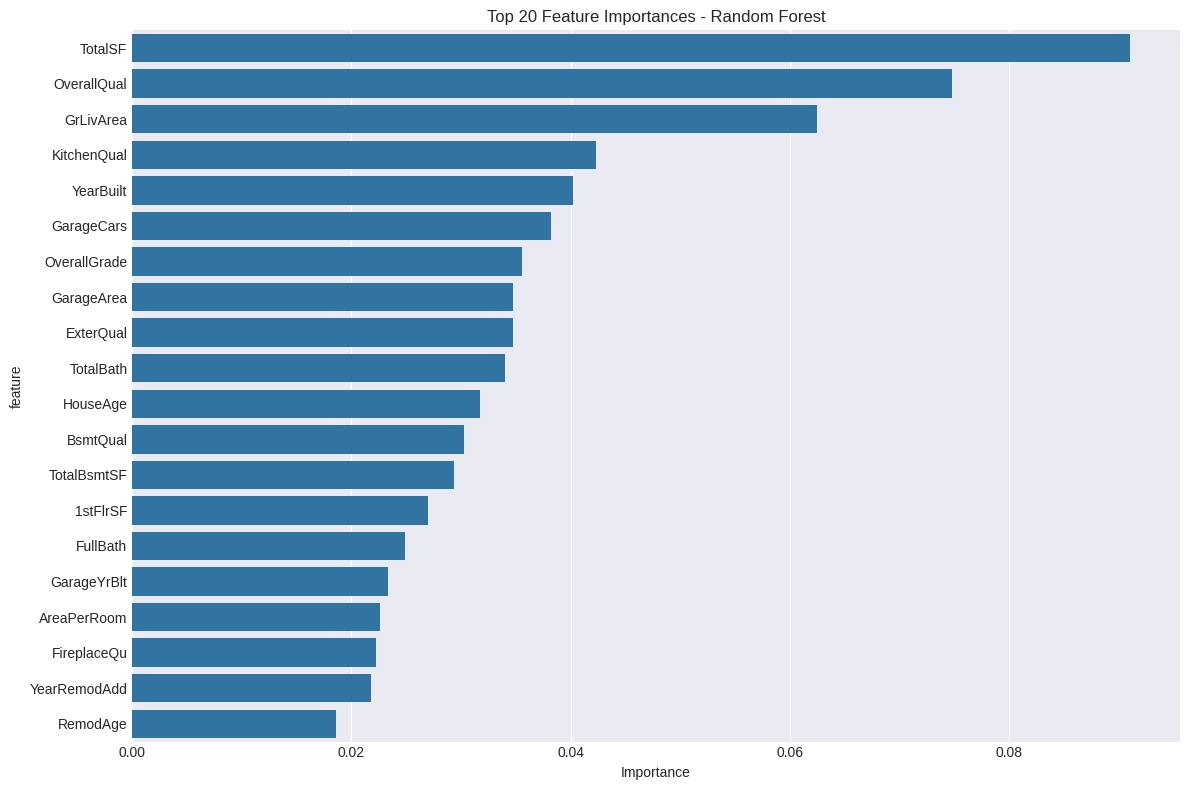


✓ Random Forest model trained!


In [29]:
"""
Train Random Forest ensemble model
"""

print("=" * 80)
print("MODEL 6: RANDOM FOREST REGRESSOR")
print("=" * 80)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=500, max_depth=15,
                                min_samples_split=10, min_samples_leaf=5,
                                max_features='sqrt', random_state=42,
                                n_jobs=-1, verbose=0)

print("\n🌲 Training Random Forest with 500 trees...")
rf_model.fit(X_train, y_train_split)

# Predictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_val_rf = rf_model.predict(X_val)

# Metrics
print("\n📊 Training Set Performance:")
calculate_metrics(y_train_split, y_pred_train_rf, "Random Forest")

print("\n📊 Validation Set Performance:")
calculate_metrics(y_val_split, y_pred_val_rf, "Random Forest")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\n✓ Random Forest model trained!")


In [30]:
"""
Train Gradient Boosting model
"""

print("=" * 80)
print("MODEL 7: GRADIENT BOOSTING REGRESSOR")
print("=" * 80)

# Train Gradient Boosting
gbm_model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,
                                     max_depth=4, min_samples_split=10,
                                     min_samples_leaf=5, subsample=0.8,
                                     random_state=42, verbose=0)

print("\n📈 Training Gradient Boosting with 500 estimators...")
gbm_model.fit(X_train, y_train_split)

# Predictions
y_pred_train_gbm = gbm_model.predict(X_train)
y_pred_val_gbm = gbm_model.predict(X_val)

# Metrics
print("\n📊 Training Set Performance:")
calculate_metrics(y_train_split, y_pred_train_gbm, "Gradient Boosting")

print("\n📊 Validation Set Performance:")
calculate_metrics(y_val_split, y_pred_val_gbm, "Gradient Boosting")

# Feature importance
feature_importance_gbm = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gbm_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 15 Most Important Features:")
print(feature_importance_gbm.head(15).to_string(index=False))

print("\n✓ Gradient Boosting model trained!")


MODEL 7: GRADIENT BOOSTING REGRESSOR

📈 Training Gradient Boosting with 500 estimators...

📊 Training Set Performance:

Gradient Boosting Performance:
  RMSE: 0.033340
  MAE:  0.024519
  R²:   0.992708

📊 Validation Set Performance:

Gradient Boosting Performance:
  RMSE: 0.134916
  MAE:  0.087459
  R²:   0.902458

📊 Top 15 Most Important Features:
     feature  importance
     TotalSF    0.345731
 OverallQual    0.309776
OverallGrade    0.047204
   TotalBath    0.032240
   GrLivArea    0.020217
  GarageCars    0.019290
     LotArea    0.017220
    HouseAge    0.015405
    BsmtQual    0.015167
 KitchenQual    0.012330
  GarageArea    0.011402
    RemodAge    0.011248
CentralAir_Y    0.009191
 FireplaceQu    0.009094
  BsmtFinSF1    0.008563

✓ Gradient Boosting model trained!


In [36]:
import xgboost as xgb

"""
Train XGBoost model for better performance
"""

print("=" * 80)
print("MODEL 8: XGBOOST")
print("=" * 80)

# Train XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05,
                            max_depth=4, min_child_weight=5,
                            subsample=0.8, colsample_bytree=0.8,
                            reg_alpha=0.1, reg_lambda=1,
                            random_state=42, n_jobs=-1,
                            verbosity=0)

print("\n🚀 Training XGBoost with 1000 estimators...")

xgb_model.fit(X_train, y_train_split,
             eval_set=[(X_val, y_val_split)])

# Predictions
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_val_xgb = xgb_model.predict(X_val)

# Metrics
print("\n📊 Training Set Performance:")
calculate_metrics(y_train_split, y_pred_train_xgb, "XGBoost")

print("\n📊 Validation Set Performance:")
calculate_metrics(y_val_split, y_pred_val_xgb, "XGBoost")

print("\n✓ XGBoost model trained!")

MODEL 8: XGBOOST

🚀 Training XGBoost with 1000 estimators...
[0]	validation_0-rmse:0.41787
[1]	validation_0-rmse:0.40288
[2]	validation_0-rmse:0.38942
[3]	validation_0-rmse:0.37590
[4]	validation_0-rmse:0.36296
[5]	validation_0-rmse:0.35128
[6]	validation_0-rmse:0.33972
[7]	validation_0-rmse:0.32861
[8]	validation_0-rmse:0.31826
[9]	validation_0-rmse:0.30818
[10]	validation_0-rmse:0.30007
[11]	validation_0-rmse:0.29204
[12]	validation_0-rmse:0.28399
[13]	validation_0-rmse:0.27614
[14]	validation_0-rmse:0.26913
[15]	validation_0-rmse:0.26172
[16]	validation_0-rmse:0.25523
[17]	validation_0-rmse:0.24921
[18]	validation_0-rmse:0.24372
[19]	validation_0-rmse:0.23845
[20]	validation_0-rmse:0.23273
[21]	validation_0-rmse:0.22747
[22]	validation_0-rmse:0.22292
[23]	validation_0-rmse:0.21867
[24]	validation_0-rmse:0.21477
[25]	validation_0-rmse:0.21078
[26]	validation_0-rmse:0.20680
[27]	validation_0-rmse:0.20321
[28]	validation_0-rmse:0.19998
[29]	validation_0-rmse:0.19643
[30]	validation_0-r

In [37]:
"""
Train CatBoost model (handles categorical features automatically)
"""

print("=" * 80)
print("MODEL 10: CATBOOST")
print("=" * 80)

# Train CatBoost
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.05,
                             depth=4, l2_leaf_reg=3,
                             subsample=0.8, random_state=42,
                             verbose=0)

print("\n🐱 Training CatBoost with 1000 iterations...")
cat_model.fit(X_train, y_train_split,
             eval_set=(X_val, y_val_split),
             early_stopping_rounds=50,
             verbose=False)

# Predictions
y_pred_train_cat = cat_model.predict(X_train)
y_pred_val_cat = cat_model.predict(X_val)

# Metrics
print("\n📊 Training Set Performance:")
calculate_metrics(y_train_split, y_pred_train_cat, "CatBoost")

print("\n📊 Validation Set Performance:")
calculate_metrics(y_val_split, y_pred_val_cat, "CatBoost")

print(f"\n✓ Best iteration: {cat_model.get_best_iteration()}")
print("\n✓ CatBoost model trained!")

MODEL 10: CATBOOST

🐱 Training CatBoost with 1000 iterations...

📊 Training Set Performance:

CatBoost Performance:
  RMSE: 0.071956
  MAE:  0.053478
  R²:   0.966036

📊 Validation Set Performance:

CatBoost Performance:
  RMSE: 0.130145
  MAE:  0.083170
  R²:   0.909235

✓ Best iteration: 487

✓ CatBoost model trained!


MODEL COMPARISON

📊 Model Performance Ranking (by Validation RMSE):
            Model  Validation RMSE
       ElasticNet         0.114978
         CatBoost         0.130145
            Ridge         0.130286
            Lasso         0.132033
Gradient Boosting         0.134916
          XGBoost         0.135939
         LightGBM         0.136079
    Random Forest         0.162339
Linear Regression         0.163408
    Decision Tree         0.183958


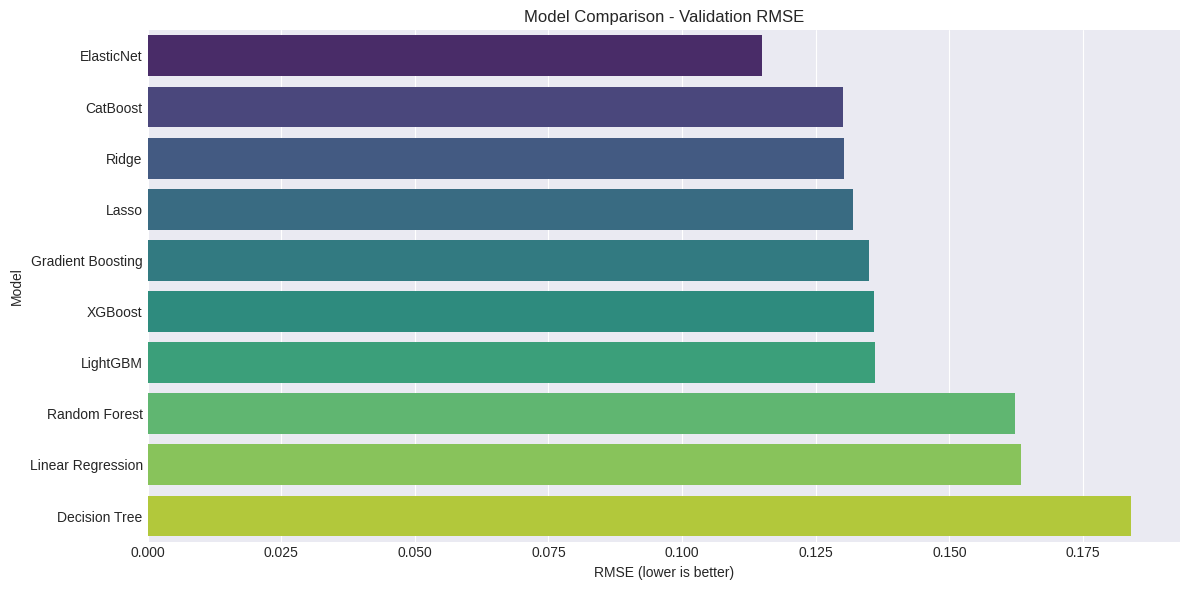


🏆 Best Model: ElasticNet
🏆 Best Validation RMSE: 0.114978


In [44]:
"""
Compare all models and select the best performer
"""

print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

# Create comparison dataframe
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'Decision Tree', 'Random Forest', 'Gradient Boosting',
              'XGBoost', 'LightGBM', 'CatBoost'],
    'Validation RMSE': [
        np.sqrt(mean_squared_error(y_val_split, y_pred_val_lr)),
        np.sqrt(mean_squared_error(y_val_split, y_pred_val_ridge)),
        np.sqrt(mean_squared_error(y_val_split, y_pred_val_lasso)),
        np.sqrt(mean_squared_error(y_val_split, y_pred_val_en)),
        np.sqrt(mean_squared_error(y_val_split, y_pred_val_dt)),
        np.sqrt(mean_squared_error(y_val_split, y_pred_val_rf)),
        np.sqrt(mean_squared_error(y_val_split, y_pred_val_gbm)),
        np.sqrt(mean_squared_error(y_val_split, y_pred_val_xgb)),
        np.sqrt(mean_squared_error(y_val_split, y_pred_val_lgb)),
        np.sqrt(mean_squared_error(y_val_split, y_pred_val_cat))
    ]
}).sort_values('Validation RMSE')

print("\n📊 Model Performance Ranking (by Validation RMSE):")
print(models_comparison.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=models_comparison, x='Validation RMSE', y='Model',
            palette='viridis')
plt.title('Model Comparison - Validation RMSE')
plt.xlabel('RMSE (lower is better)')
plt.tight_layout()
plt.show()

best_model_name = models_comparison.iloc[0]['Model']
best_rmse = models_comparison.iloc[0]['Validation RMSE']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"🏆 Best Validation RMSE: {best_rmse:.6f}")

In [42]:
"""
Train LightGBM model for fast and efficient gradient boosting
"""

print("=" * 80)
print("MODEL 9: LIGHTGBM")
print("=" * 80)

MODEL 9: LIGHTGBM


In [43]:
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05,
                             max_depth=4, num_leaves=31,
                             min_child_samples=20, subsample=0.8,
                             colsample_bytree=0.8, reg_alpha=0.1,
                             reg_lambda=1, random_state=42,
                             n_jobs=-1, verbose=-1)

print("\n⚡ Training LightGBM with 1000 estimators...")
lgb_model.fit(X_train, y_train_split,
             eval_set=[(X_val, y_val_split)],
             callbacks=[lgb.early_stopping(50, verbose=False)])

# Predictions
y_pred_train_lgb = lgb_model.predict(X_train)
y_pred_val_lgb = lgb_model.predict(X_val)

# Metrics
print("\n📊 Training Set Performance:")
calculate_metrics(y_train_split, y_pred_train_lgb, "LightGBM")

print("\n📊 Validation Set Performance:")
calculate_metrics(y_val_split, y_pred_val_lgb, "LightGBM")

print(f"\n✓ Best iteration: {lgb_model.best_iteration_}")
print("\n✓ LightGBM model trained!")


⚡ Training LightGBM with 1000 estimators...

📊 Training Set Performance:

LightGBM Performance:
  RMSE: 0.065144
  MAE:  0.045420
  R²:   0.972161

📊 Validation Set Performance:

LightGBM Performance:
  RMSE: 0.136079
  MAE:  0.088492
  R²:   0.900770

✓ Best iteration: 313

✓ LightGBM model trained!


In [45]:
"""
Create an ensemble by averaging predictions from top models
"""

print("=" * 80)
print("ENSEMBLE MODEL - WEIGHTED AVERAGE")
print("=" * 80)

# Retrain best models on full training data
print("\n🔄 Retraining top models on full training set...")

# XGBoost
xgb_final = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05,
                            max_depth=4, min_child_weight=5,
                            subsample=0.8, colsample_bytree=0.8,
                            reg_alpha=0.1, reg_lambda=1,
                            random_state=42, n_jobs=-1, verbosity=0)
xgb_final.fit(X_train_scaled, y_train_log,
             verbose=False)

# LightGBM
lgb_final = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05,
                             max_depth=4, num_leaves=31,
                             min_child_samples=20, subsample=0.8,
                             colsample_bytree=0.8, reg_alpha=0.1,
                             reg_lambda=1, random_state=42,
                             n_jobs=-1, verbose=-1)
lgb_final.fit(X_train_scaled, y_train_log)

# CatBoost
cat_final = CatBoostRegressor(iterations=1000, learning_rate=0.05,
                             depth=4, l2_leaf_reg=3,
                             subsample=0.8, random_state=42,
                             verbose=0)
cat_final.fit(X_train_scaled, y_train_log, verbose=False)

# Ridge
ridge_final = Ridge(alpha=best_alpha, random_state=42)
ridge_final.fit(X_train_scaled, y_train_log)

# Random Forest
rf_final = RandomForestRegressor(n_estimators=500, max_depth=15,
                                min_samples_split=10, min_samples_leaf=5,
                                max_features='sqrt', random_state=42,
                                n_jobs=-1, verbose=0)
rf_final.fit(X_train_scaled, y_train_log)

print("\n✓ All models retrained on full dataset!")

# Weighted ensemble predictions
def ensemble_predict(X, weights=None):
    if weights is None:
        weights = [0.25, 0.25, 0.25, 0.15, 0.10]  # XGB, LGB, CAT, Ridge, RF

    pred_xgb = xgb_final.predict(X)
    pred_lgb = lgb_final.predict(X)
    pred_cat = cat_final.predict(X)
    pred_ridge = ridge_final.predict(X)
    pred_rf = rf_final.predict(X)

    ensemble_pred = (weights[0] * pred_xgb +
                    weights[1] * pred_lgb +
                    weights[2] * pred_cat +
                    weights[3] * pred_ridge +
                    weights[4] * pred_rf)
    return ensemble_pred

print("\n📊 Ensemble weights:")
print("  XGBoost:        25%")
print("  LightGBM:       25%")
print("  CatBoost:       25%")
print("  Ridge:          15%")
print("  Random Forest:  10%")

print("\n✓ Ensemble model created!")


ENSEMBLE MODEL - WEIGHTED AVERAGE

🔄 Retraining top models on full training set...

✓ All models retrained on full dataset!

📊 Ensemble weights:
  XGBoost:        25%
  LightGBM:       25%
  CatBoost:       25%
  Ridge:          15%
  Random Forest:  10%

✓ Ensemble model created!


GENERATING TEST SET PREDICTIONS

🔮 Generating ensemble predictions for test set...

✓ Generated 1459 predictions
📊 Prediction range: $51,308.10 - $500,252.38
📊 Mean prediction: $177,157.17
📊 Median prediction: $156,173.38


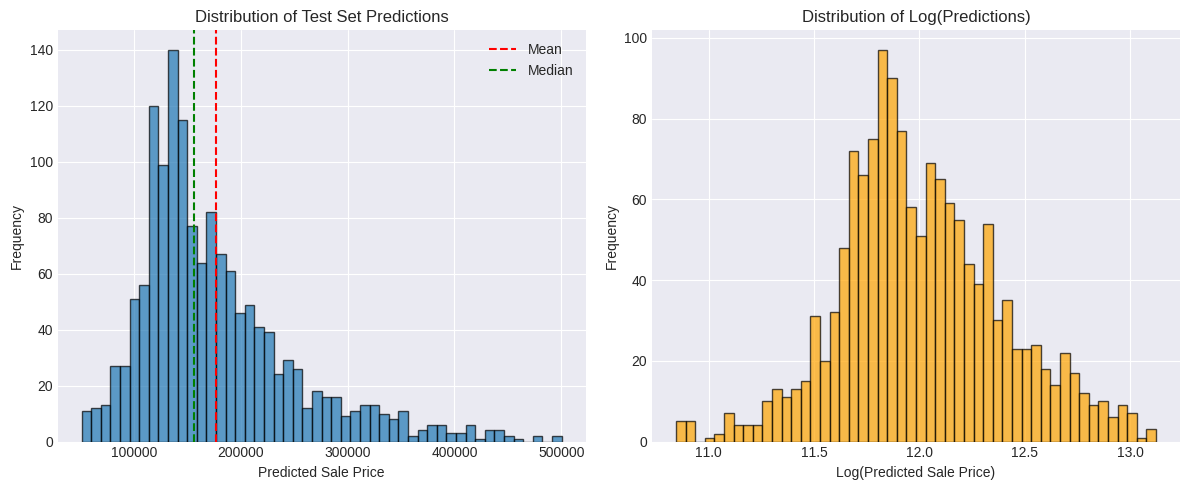


✓ Test predictions generated successfully!


In [46]:
"""
Generate final predictions for the test set
"""

print("=" * 80)
print("GENERATING TEST SET PREDICTIONS")
print("=" * 80)

# Generate ensemble predictions
print("\n🔮 Generating ensemble predictions for test set...")
test_predictions_log = ensemble_predict(X_test_scaled)

# Transform back from log scale
test_predictions = np.expm1(test_predictions_log)

print(f"\n✓ Generated {len(test_predictions)} predictions")
print(f"📊 Prediction range: ${test_predictions.min():,.2f} - ${test_predictions.max():,.2f}")
print(f"📊 Mean prediction: ${test_predictions.mean():,.2f}")
print(f"📊 Median prediction: ${np.median(test_predictions):,.2f}")

# Visualize predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_predictions, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Test Set Predictions')
plt.axvline(test_predictions.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(np.median(test_predictions), color='green', linestyle='--', label='Median')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(np.log1p(test_predictions), bins=50, edgecolor='black',
         alpha=0.7, color='orange')
plt.xlabel('Log(Predicted Sale Price)')
plt.ylabel('Frequency')
plt.title('Distribution of Log(Predictions)')

plt.tight_layout()
plt.show()

print("\n✓ Test predictions generated successfully!")




In [49]:
"""
Create the submission file in the required format
"""

print("=" * 80)
print("CREATING SUBMISSION FILE")
print("=" * 80)

# Create submission dataframe
submission = pd.DataFrame({
    'Id': test_id,
    'SalePrice': test_predictions
})

# Save submission file
submission_filename = 'house_prices_submission.csv'
submission.to_csv(submission_filename, index=False)

print(f"\n✅ Submission file created: {submission_filename}")
print(f"📊 Submission shape: {submission.shape}")
print("\n📋 First 10 rows of submission:")
print(submission.head(10))

print("\n" + "=" * 80)


print("\n" + "=" * 80)

print("=" * 80)



CREATING SUBMISSION FILE

✅ Submission file created: house_prices_submission.csv
📊 Submission shape: (1459, 2)

📋 First 10 rows of submission:
     Id      SalePrice
0  1461  122963.507979
1  1462  162077.411243
2  1463  183069.536629
3  1464  194791.405906
4  1465  183912.462747
5  1466  174149.194093
6  1467  179620.891818
7  1468  167000.299126
8  1469  181286.048934
9  1470  123039.859780




ADDITIONAL INSIGHTS


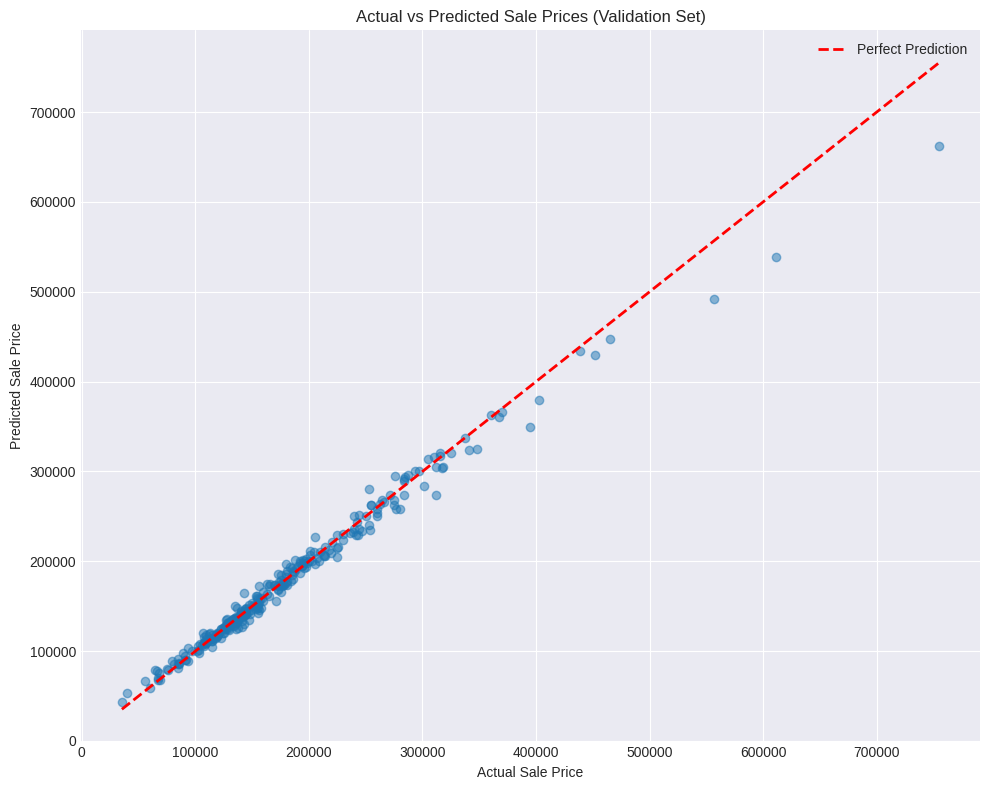

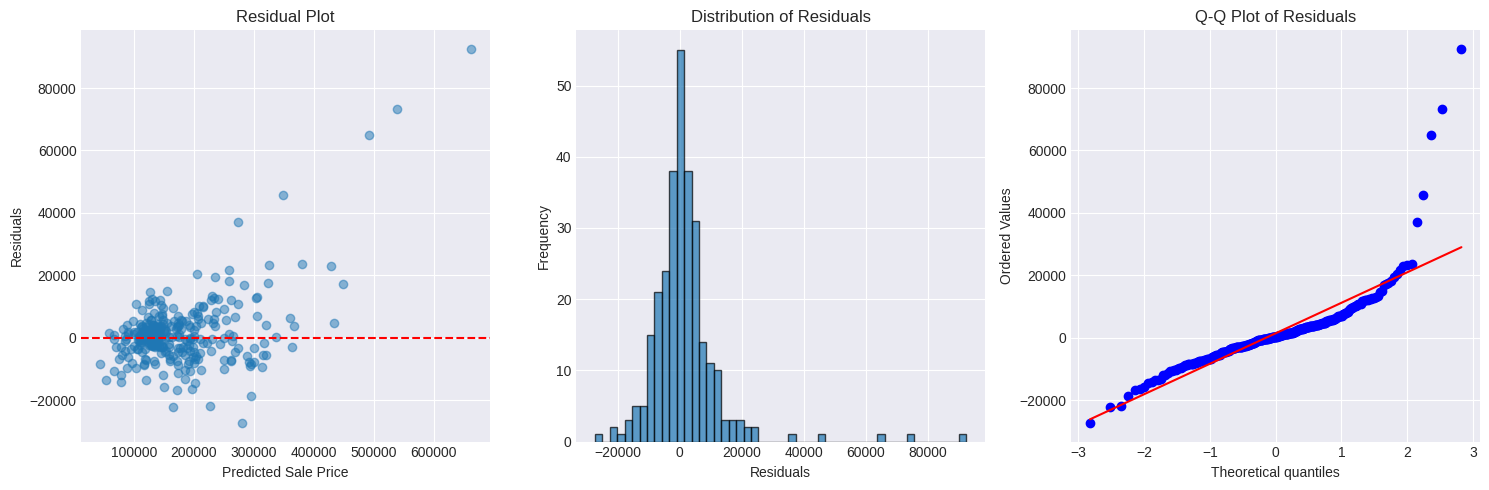


📊 ENSEMBLE MODEL - VALIDATION SET PERFORMANCE:
  RMSE (log scale): 0.052019
  MAE (original scale): $6,574.34
  R² Score: 0.982935

✓ Analysis complete!



In [51]:
"""
Provide additional insights and analysis
"""

print("=" * 80)
print("ADDITIONAL INSIGHTS")
print("=" * 80)

# Compare actual vs predicted on validation set
ensemble_val_pred_log = ensemble_predict(X_val)
ensemble_val_pred = np.expm1(ensemble_val_pred_log)
y_val_actual = np.expm1(y_val_split)

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_val_actual, ensemble_val_pred, alpha=0.5)
plt.plot([y_val_actual.min(), y_val_actual.max()],
         [y_val_actual.min(), y_val_actual.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Prices (Validation Set)')
plt.legend()
plt.tight_layout()
plt.show()

# Residual analysis
residuals = y_val_actual - ensemble_val_pred

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(ensemble_val_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1, 3, 2)
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.subplot(1, 3, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Performance metrics on validation set
ensemble_val_rmse = np.sqrt(mean_squared_error(y_val_split, ensemble_val_pred_log))
ensemble_val_mae = mean_absolute_error(y_val_actual, ensemble_val_pred)
ensemble_val_r2 = r2_score(y_val_actual, ensemble_val_pred)

print("\n📊 ENSEMBLE MODEL - VALIDATION SET PERFORMANCE:")
print(f"  RMSE (log scale): {ensemble_val_rmse:.6f}")
print(f"  MAE (original scale): ${ensemble_val_mae:,.2f}")
print(f"  R² Score: {ensemble_val_r2:.6f}")

print("\n✓ Analysis complete!")
print("\n" + "=" * 80)
print("=" * 80)